# Purpose: Develop a much better normalization algorithm using the image background. Here I found that this normalization algorithm was much more consistent than ZScale, which would sometimes have faulty outputs.

In [1]:
import glob
import cupy as cp
import numpy as np
from astropy.io import fits
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize
import random
import matplotlib.pyplot as plt
import sep
from tqdm.notebook import tqdm

In [2]:
size = 80

In [37]:
filenames = glob.glob("/mnt/etdisk9/ztf_neos/real_streaks/science/*.fits")

In [36]:
filenames = glob.glob("/mnt/etdisk9/ztf_neos/real_streaks/reference/*.fits")

In [38]:
def normalize(image, back, rms, sigma1=5, sigma2=5):
    
    image = np.array(image)
    
    image -= back
    
    image /= rms
    
    return np.clip(image, -sigma2, sigma1)


def normalize_old(arr, samples=size * size):
    arr = np.copy(arr)
    vmin, vmax = ZScaleInterval(samples).get_limits(arr)
    arr -= vmin
    arr /= vmax - vmin
    arr = np.clip(arr, 0, 1)

    return (arr - np.nanmedian(arr, axis=(0, 1), keepdims=True)) / np.nanstd(arr, axis=(0, 1), keepdims=True)

In [39]:
%%timeit
data = fits.getdata(np.random.choice(filenames))
data = data.astype(np.float32)

bkg = sep.Background(data)
normalized = normalize(data, bkg.back(), bkg.rms())

631 ms ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%time
data = fits.getdata(np.random.choice(filenames))
data = data.astype(np.float32)

CPU times: user 42.5 ms, sys: 43.3 ms, total: 85.7 ms
Wall time: 361 ms


In [41]:
%%time

bkg = sep.Background(data)
normalized = normalize(data, bkg.back(), bkg.rms())

CPU times: user 241 ms, sys: 18.8 ms, total: 260 ms
Wall time: 256 ms


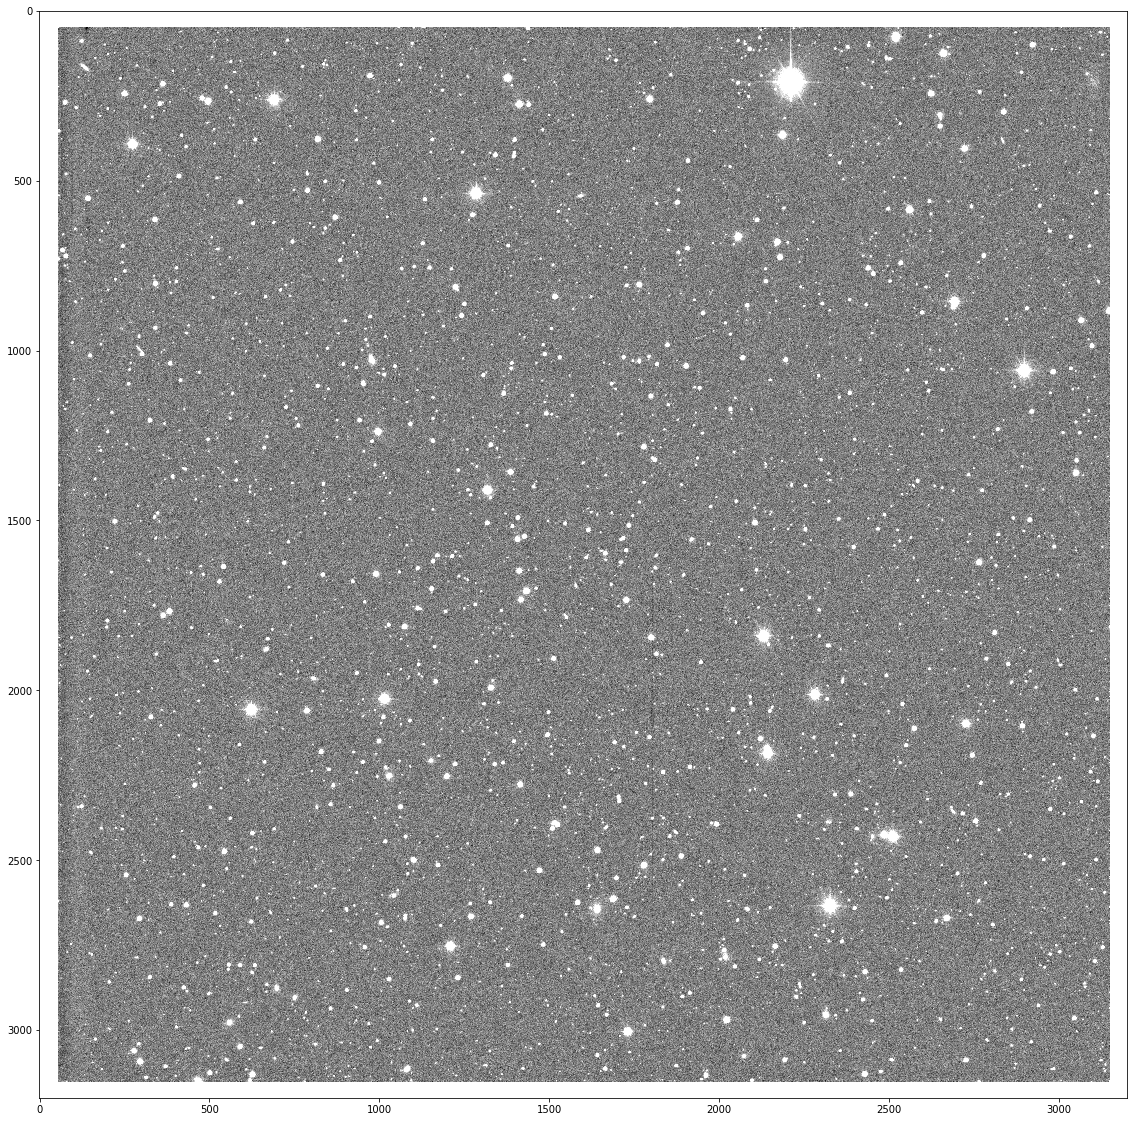

In [6]:
data = fits.getdata(np.random.choice(filenames))
data = data.astype(np.float32)

bkg = sep.Background(data)
normalized = normalize(data, bkg.back(), bkg.rms())

plt.figure(figsize=(20, 20))
plt.imshow(normalized, cmap="gray")

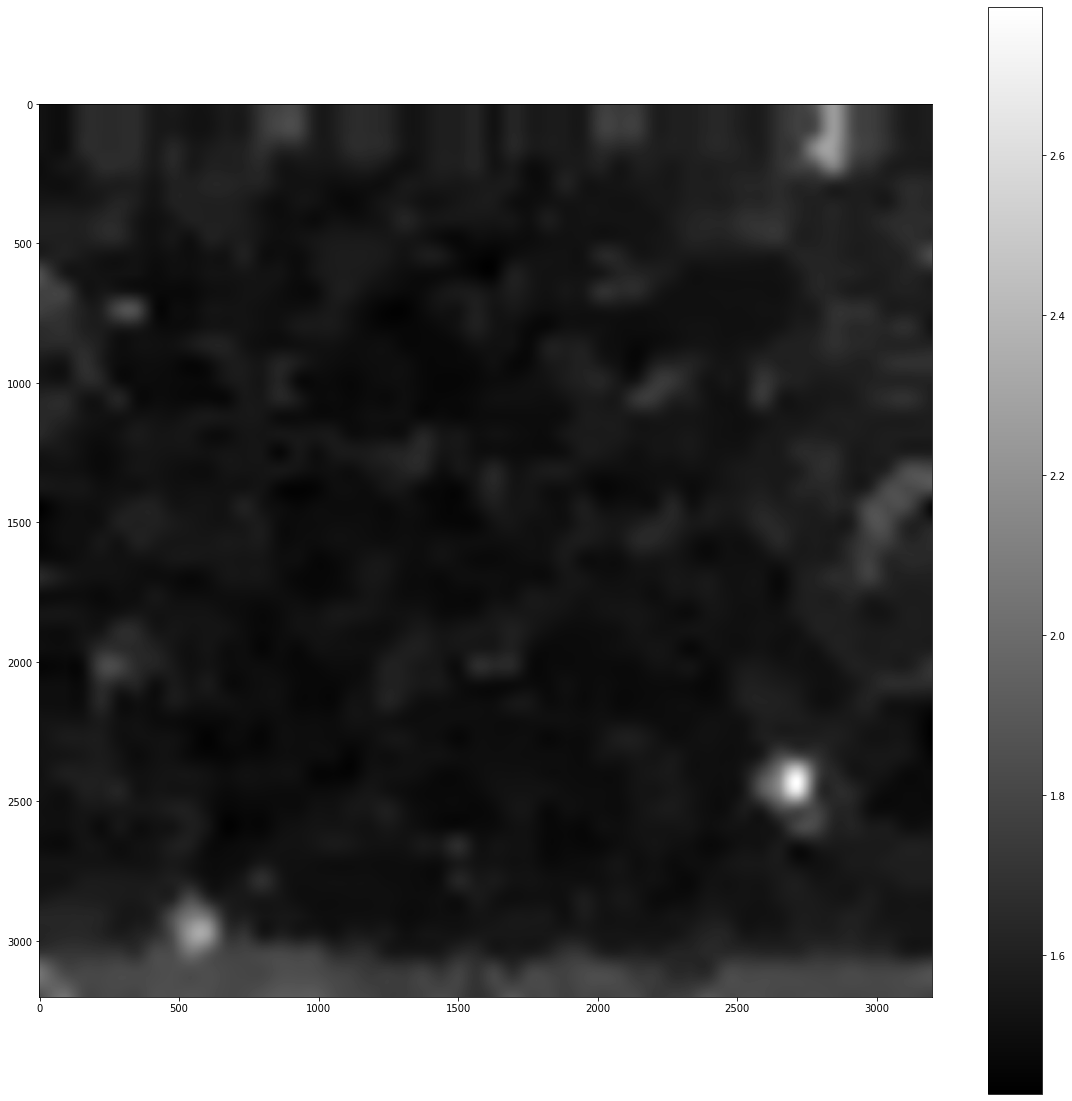

In [316]:
plt.figure(figsize=(20, 20))
plt.imshow(bkg.rms(), cmap="gray")
plt.colorbar()

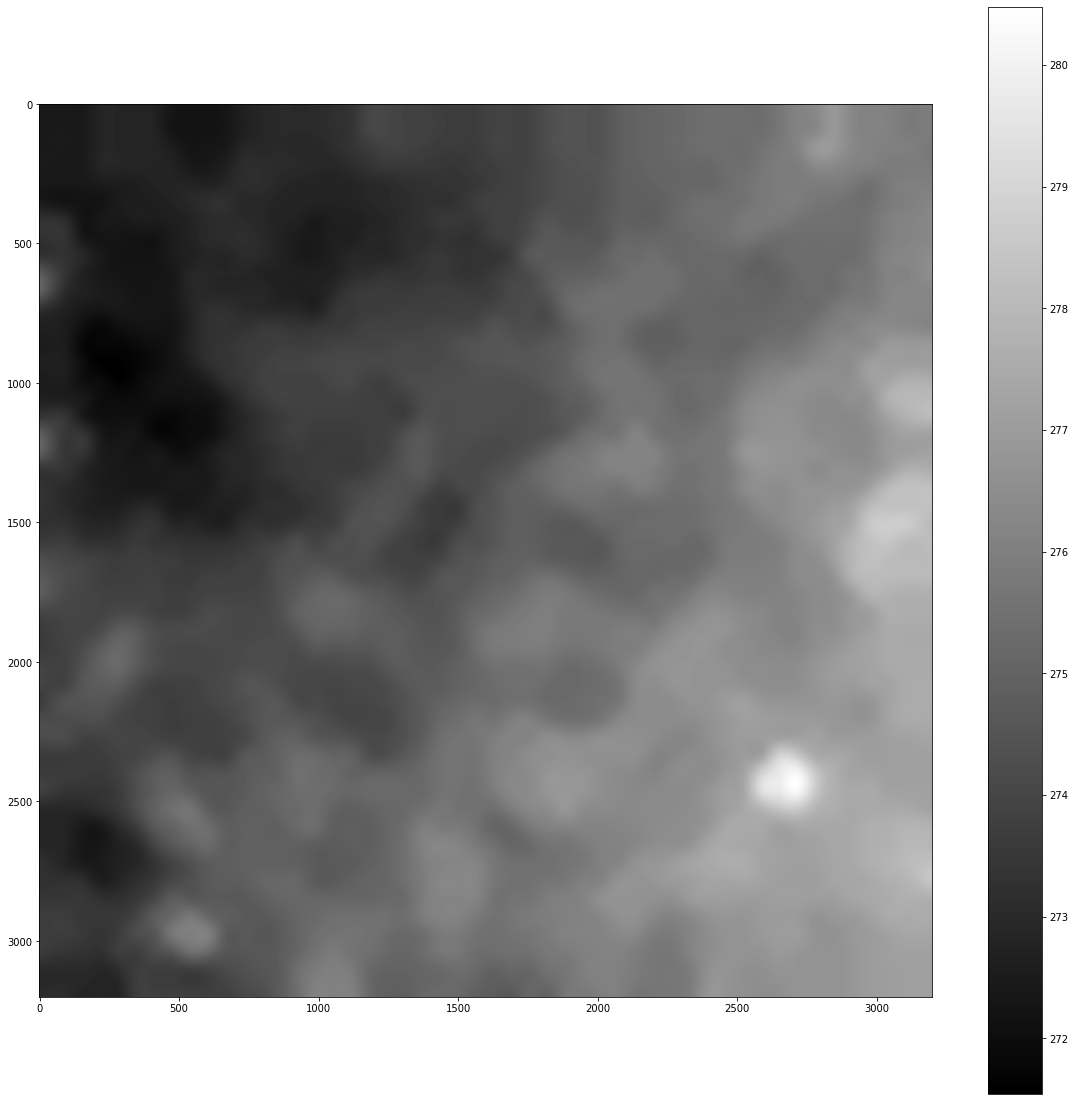

In [317]:
plt.figure(figsize=(20, 20))
plt.imshow(bkg.back(), cmap="gray")
plt.colorbar()

/opt/anaconda/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.350000e+02, 7.280000e+03, 1.502420e+05, 1.106019e+06,
        2.929893e+06, 2.870501e+06, 1.166477e+06, 3.096080e+05,
        1.231940e+05, 5.817000e+05]),
 array([-4.932764  , -3.9394877 , -2.9462113 , -1.9529349 , -0.95965844,
         0.03361797,  1.0268943 ,  2.0201707 ,  3.0134473 ,  4.0067234 ,
         5.        ], dtype=float32),
 <a list of 10 Patch objects>)

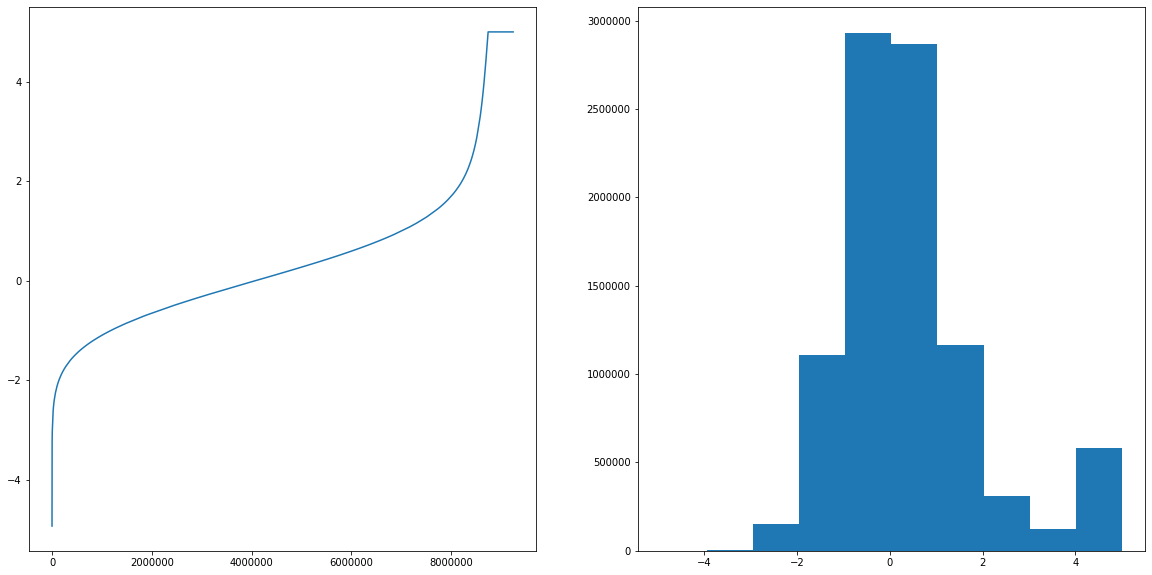

In [313]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(np.sort(normalized.flat))
ax[1].hist(normalized.flat)

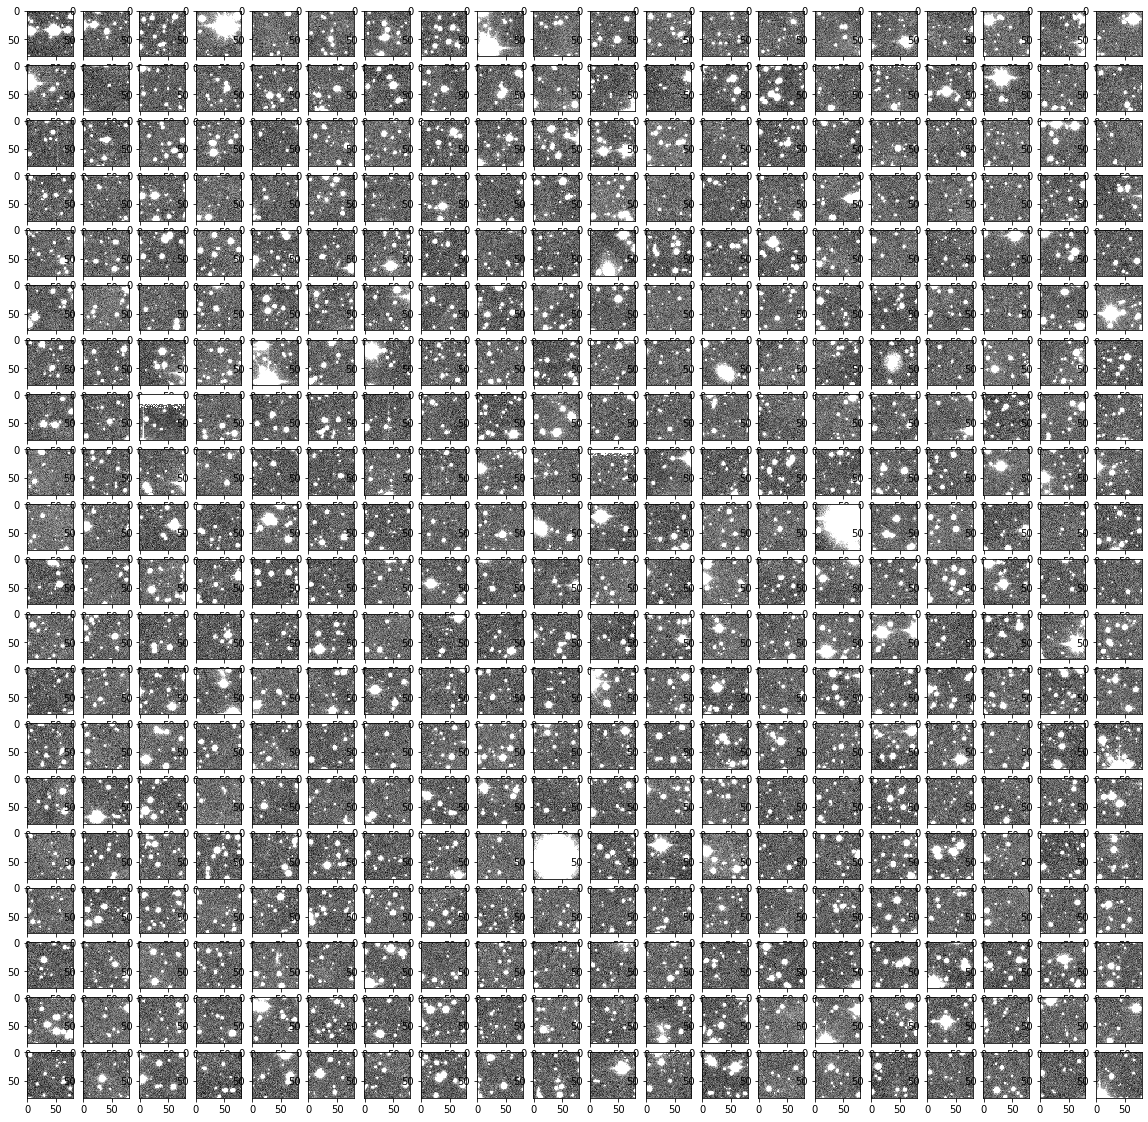

In [300]:
fig, axs = plt.subplots(20, 20, squeeze=False, figsize=(20, 20))

axs = axs.flatten()

bounds = []

for i in range(400):
    x = random.randint(100, 2800)
    y = random.randint(100, 2800)
    bounds.append((x, y))
    
    axs[i].imshow(normalized[y:y+size, x:x+size], cmap="gray")

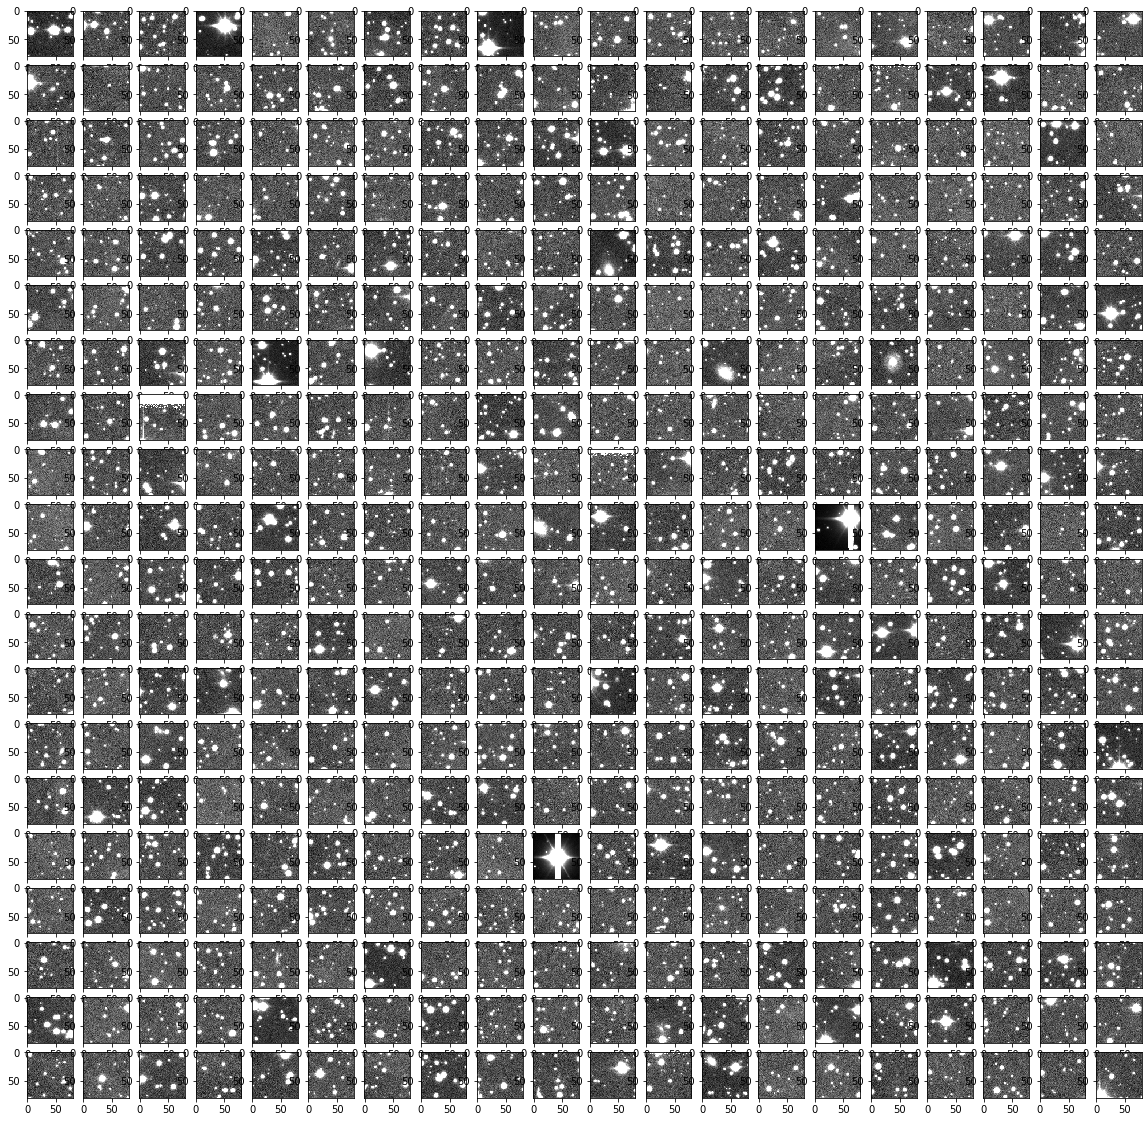

In [303]:
fig, axs = plt.subplots(20, 20, squeeze=False, figsize=(20, 20))

axs = axs.flatten()

for i, (x,y) in tqdm(list(enumerate(bounds))):
    
    axs[i].imshow(normalize_old(data[y:y+size, x:x+size]), cmap="gray")

/opt/anaconda/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 402., 2965., 1237.,  412.,  225.,  128.,  103.,   81.,   67.,
         584.]),
 array([-0.7072653 , -0.3316    ,  0.04406529,  0.41973057,  0.7953959 ,
         1.1710612 ,  1.5467265 ,  1.9223918 ,  2.298057  ,  2.6737225 ,
         3.0493877 ], dtype=float32),
 <a list of 10 Patch objects>)

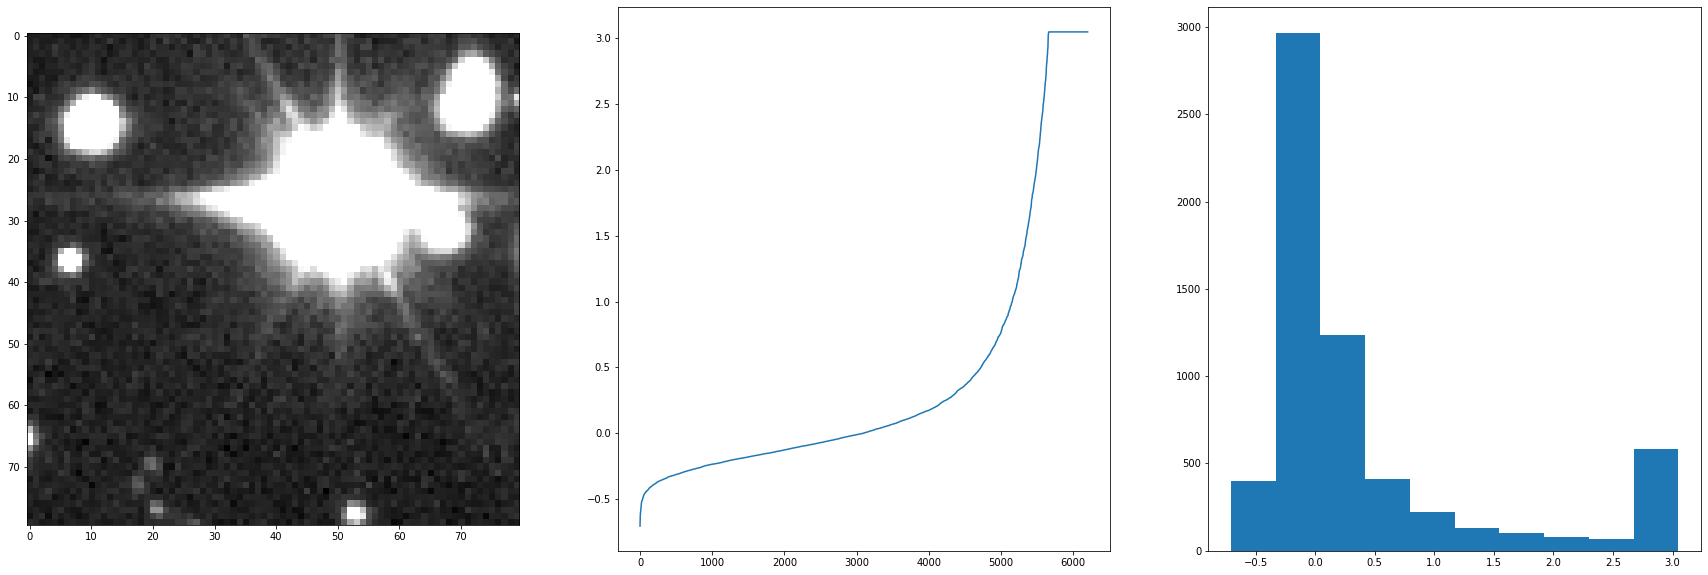

In [310]:
x, y = bounds[3]

image = data[y:y+size, x:x+size]

# image = normalize(image, bkg.back()[y:y+size, x:x+size], bkg.rms()[y:y+size, x:x+size], sigma2=5)
image = normalize_old(image)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))

ax[0].imshow(image, cmap="gray")
ax[1].plot(np.sort(image.flat))
ax[2].hist(image.flat)

In [147]:
%%time
data = fits.getdata(np.random.choice(filenames))
data = data.astype(np.float32)

bkg = sep.Background(data)

CPU times: user 190 ms, sys: 16.2 ms, total: 206 ms
Wall time: 388 ms


(array([  43.,  354., 1038., 1782., 1694.,  908.,  255.,   74.,   32.,
         220.]),
 array([416.8966 , 424.37927, 431.86194, 439.3446 , 446.82727, 454.30994,
        461.79257, 469.27524, 476.7579 , 484.24057, 491.72324],
       dtype=float32),
 <a list of 10 Patch objects>)

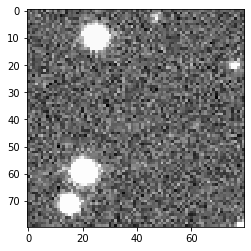

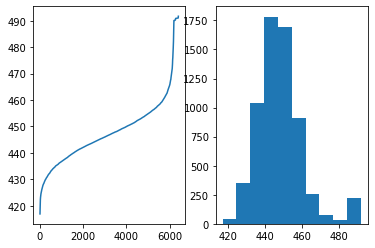

In [148]:
x = random.randint(100, 2800)
y = random.randint(100, 2800)

image = data[y:y+size, x:x+size]

### LOG NORM
# image = (image - np.min(image)) / np.ptp(image)
# a = 5000
# image = np.log10(a * image + 1) / np.log10(a)

### OUTLIER
thresh = (bkg.back() + 5 * bkg.rms())[y:y+size, x:x+size]
indices = image > thresh
image[indices] = thresh[indices]

# pix = np.sort(image.flat)
# diffs = pix[1:] - pix[:-1]

# plt.plot(np.sort(diffs))

# plt.figure()
# plt.imshow(image, cmap="gray")

# plt.figure()
# plt.subplot(1, 2, 1)
# plt.plot(np.sort(image.flatten()))
# plt.subplot(1, 2, 2)
# plt.hist(image.flatten())

In [323]:
np.random.randn(300, 300)[((slice(50, 100), slice(50, 100)), (slice(50, 100), slice(50, 100)))]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [324]:
import astroscrappy

In [327]:
sci = fits.getdata(filenames[0])

In [331]:
%%timeit
astroscrappy.detect_cosmics(sci[100:180, 100:180])

901 ms ± 78.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
